<a href="https://colab.research.google.com/github/ShounakDas101/AIML_Hari/blob/main/Softmax_CERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import h5py
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
import torch.optim as optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Specify the path to the file in your Google Drive
file_path = '/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
CHECKPOINT_PATH = '/content/drive/MyDrive/CHECKPOINTS'

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

The file '/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5' exists.


In [ ]:
# clearing cuda cache memory
import gc
torch.cuda.empty_cache()
gc.collect()

6

In [ ]:
import h5py

def find_keys(hdf5_obj, path='/'):
    """Recursively find keys in an HDF5 file."""
    keys = []
    for key in hdf5_obj[path].keys():
        full_path = f"{path}/{key}"
        keys.append(full_path)
        if isinstance(hdf5_obj[full_path], h5py.Group):
            keys.extend(find_keys(hdf5_obj, full_path))
    return keys

# Open the HDF5 file
file_path = '/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'  # Replace with your actual file path
with h5py.File(file_path, 'r') as hdf5_file:
    # Find keys starting from the root
    all_keys = find_keys(hdf5_file)

# Print the found keys
for key in all_keys:
    print(key)


//X
//y


In [ ]:
# import dataset

# importing electron dataset and seperating images and labels
electron_dataset = h5py.File("/content/drive/MyDrive/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5","r")
electron_imgs=np.array(electron_dataset["X"])
electron_labels=np.array(electron_dataset["y"],dtype=np.int64)

# importing photon dataset and seperating images and labels
photon_dataset = h5py.File("/content/drive/MyDrive/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5","r")
photon_imgs=np.array(photon_dataset["X"])
photon_labels=np.array(photon_dataset["y"],dtype=np.int64)

In [ ]:
print(electron_imgs.shape)
print(electron_labels)

(249000, 32, 32, 2)
[1 1 1 ... 1 1 1]


(249000, 32, 32, 2)


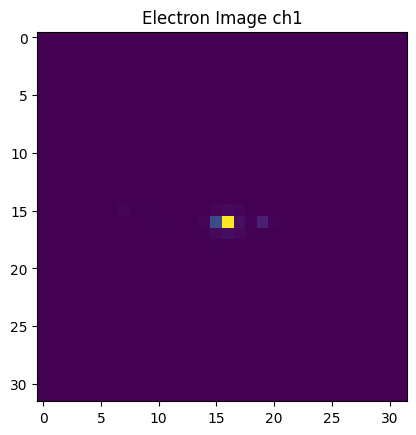

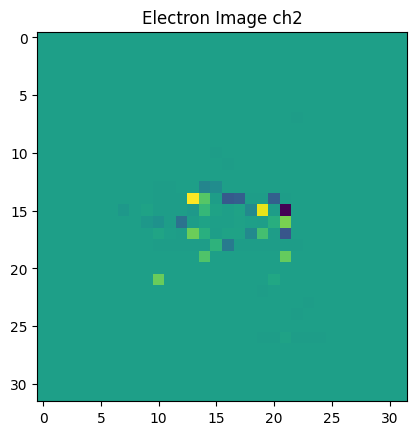

In [ ]:
import matplotlib.pyplot as plt
print(electron_imgs.shape)
for electron_imgs1 in electron_imgs[:1]:
  # Display the first image from electron_imgs
  plt.imshow(electron_imgs1[:, :, 0])  # Assuming it's a 2-channel image; adjust if needed
  plt.title('Electron Image ch1')
  plt.show()

  # Display the first image from photon_imgs
  plt.imshow(electron_imgs1[:, :, 1])  # Assuming it's a 2-channel image; adjust if needed
  plt.title('Electron Image ch2')
  plt.show()



(249000, 32, 32, 2)


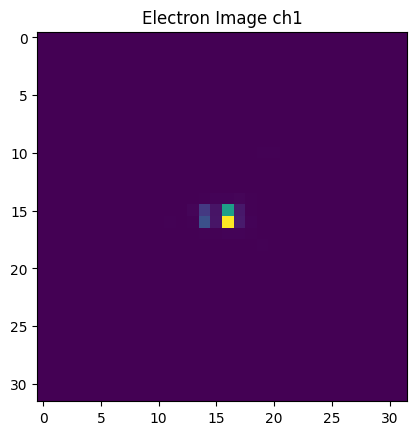

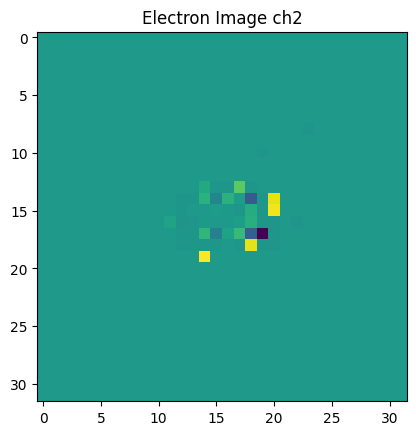

In [ ]:
import matplotlib.pyplot as plt
print(electron_imgs.shape)
for photon_imgs1 in photon_imgs[:1]:
  # Display the first image from electron_imgs
  plt.imshow(photon_imgs1[:, :, 0])  # Assuming it's a 2-channel image; adjust if needed
  plt.title('Electron Image ch1')
  plt.show()

  # Display the first image from photon_imgs
  plt.imshow(photon_imgs1[:, :, 1])  # Assuming it's a 2-channel image; adjust if needed
  plt.title('Electron Image ch2')
  plt.show()



In [ ]:
# concatenate electron and photon images/labels
img_arrs = torch.Tensor(np.vstack((photon_imgs,electron_imgs)))
labels = torch.Tensor(np.hstack((photon_labels,electron_labels))).to(torch.int64)
img_arrs = img_arrs.permute(0,3,1,2)
print(img_arrs.shape)

torch.Size([498000, 2, 32, 32])


In [ ]:
del electron_imgs,photon_imgs,electron_labels,photon_labels

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'label': self.labels[idx]}
        return sample

In [ ]:
# Assuming img_arrs and labels are already defined
custom_dataset = CustomDataset(img_arrs, labels)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(custom_dataset))
valid_size = int(0.2 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(custom_dataset, [train_size, valid_size, test_size])
print(len(valid_dataset)+len(test_dataset)+len(train_dataset))

498000


In [ ]:
# Create DataLoaders for training, validation, and test sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs = next(iter(train_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs['image'].shape, "\n")
print("Full",data_inputs)

Data inputs torch.Size([64, 2, 32, 32]) 

Full {'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [ ]:
my_conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
output=my_conv1((data_inputs['image']))
print(output.shape)
relu = nn.ReLU()
output=output.view(batch_size,-1)
print(output.shape[0],output.shape[1])
fc = nn.Linear(output.shape[1],2)
fc(output)

RuntimeError: ignored

In [ ]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # Output layer with 2 classes (electrons and photons)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNNModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    print(epoch, end="\n")
    for inputs in train_loader:
        if inputs['image'].shape[0] < 64:
            print("false")
            break
        inputs['image'] = inputs['image'].to(device)
        inputs['label'] = inputs['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs['image'])
        loss = criterion(outputs, inputs['label'].long())
        loss.backward()
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs in test_loader:
            inputs['image'] = inputs['image'].to(device)
            inputs['label'] = inputs['label'].to(device)
            outputs = model(inputs['image'])
            _, predicted = torch.max(outputs, 1)
            total += inputs['label'].size(0)
            correct += (predicted == inputs['label']).sum().item()

    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Accuracy: {accuracy * 100:.2f}%")
from sklearn.metrics import roc_auc_score

0
false
Epoch 1/10 - Test Accuracy: 68.46%
1
false
Epoch 2/10 - Test Accuracy: 70.67%
2
false
Epoch 3/10 - Test Accuracy: 70.12%
3
false
Epoch 4/10 - Test Accuracy: 71.64%
4
false
Epoch 5/10 - Test Accuracy: 71.94%
5


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import roc_auc_score

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 64 * 8 * 8)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fcshoun = nn.Linear(64 * 8 * 8, 128)
        self.relushoun = nn.ReLU()
        self.dropoutshoun = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # Output layer with 2 classes (electrons and photons)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fcshoun(x)
        x = self.relushoun(x)
        x = self.dropoutshoun(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNNModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    # print(epoch, end="\n")
    for inputs in train_loader:
        if inputs['image'].shape[0] < 64:
            # print("false")
            break
        inputs['image'] = inputs['image'].to(device)
        inputs['label'] = inputs['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs['image'])
        loss = criterion(outputs, inputs['label'].long())
        loss.backward()
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs in test_loader:
            inputs['image'] = inputs['image'].to(device)
            inputs['label'] = inputs['label'].to(device)
            outputs = model(inputs['image'])
            _, predicted = torch.max(outputs, 1)
            total += inputs['label'].size(0)
            correct += (predicted == inputs['label']).sum().item()

            # Calculate ROC-AUC
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(inputs['label'].cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming class 1 is the positive class

    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Accuracy: {accuracy * 100:.2f}%")

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f"Epoch {epoch + 1}/{num_epochs} - ROC AUC: {roc_auc:.4f}")


Epoch 1/20 - Test Accuracy: 68.58%
Epoch 1/20 - ROC AUC: 0.7409
Epoch 2/20 - Test Accuracy: 70.18%
Epoch 2/20 - ROC AUC: 0.7631
Epoch 3/20 - Test Accuracy: 71.09%
Epoch 3/20 - ROC AUC: 0.7721
Epoch 4/20 - Test Accuracy: 71.13%
Epoch 4/20 - ROC AUC: 0.7744
Epoch 5/20 - Test Accuracy: 71.80%
Epoch 5/20 - ROC AUC: 0.7806
Epoch 6/20 - Test Accuracy: 71.74%
Epoch 6/20 - ROC AUC: 0.7822
Epoch 7/20 - Test Accuracy: 70.92%
Epoch 7/20 - ROC AUC: 0.7781
Epoch 8/20 - Test Accuracy: 71.36%
Epoch 8/20 - ROC AUC: 0.7828
Epoch 9/20 - Test Accuracy: 71.91%
Epoch 9/20 - ROC AUC: 0.7850
Epoch 10/20 - Test Accuracy: 72.29%
Epoch 10/20 - ROC AUC: 0.7865
Epoch 11/20 - Test Accuracy: 72.07%
Epoch 11/20 - ROC AUC: 0.7875
Epoch 12/20 - Test Accuracy: 72.18%
Epoch 12/20 - ROC AUC: 0.7898
Epoch 13/20 - Test Accuracy: 72.59%
Epoch 13/20 - ROC AUC: 0.7918
Epoch 14/20 - Test Accuracy: 72.30%
Epoch 14/20 - ROC AUC: 0.7923
Epoch 15/20 - Test Accuracy: 72.55%
Epoch 15/20 - ROC AUC: 0.7909
Epoch 16/20 - Test Accuracy:

In [ ]:
from tqdm import tqdm

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 64 * 8 * 8)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fcshoun = nn.Linear(64 * 8 * 8, 128)
        self.relushoun = nn.ReLU()
        self.dropoutshoun = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # Output layer with 2 classes (electrons and photons)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fcshoun(x)
        x = self.relushoun(x)
        x = self.dropoutshoun(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNNModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training the model
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    # print(epoch, end="\n")
    for inputs in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        if inputs['image'].shape[0] < 64:
            # print("false")
            break
        inputs['image'] = inputs['image'].to(device)
        inputs['label'] = inputs['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs['image'])
        loss = criterion(outputs, inputs['label'].long())
        loss.backward()
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Testing"):
            inputs['image'] = inputs['image'].to(device)
            inputs['label'] = inputs['label'].to(device)
            outputs = model(inputs['image'])
            _, predicted = torch.max(outputs, 1)
            total += inputs['label'].size(0)
            correct += (predicted == inputs['label']).sum().item()

            # Calculate ROC-AUC
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(inputs['label'].cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming class 1 is the positive class

    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Accuracy: {accuracy * 100:.2f}%")

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f"Epoch {epoch + 1}/{num_epochs} - ROC AUC: {roc_auc:.4f}")


Epoch 1/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 410.27it/s]


Epoch 1/30 - Test Accuracy: 67.39%
Epoch 1/30 - ROC AUC: 0.7413


Epoch 2/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 426.80it/s]


Epoch 2/30 - Test Accuracy: 70.09%
Epoch 2/30 - ROC AUC: 0.7628


Epoch 3/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 354.00it/s]


Epoch 3/30 - Test Accuracy: 71.09%
Epoch 3/30 - ROC AUC: 0.7723


Epoch 4/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 349.32it/s]


Epoch 4/30 - Test Accuracy: 71.56%
Epoch 4/30 - ROC AUC: 0.7791


Epoch 5/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 424.87it/s]


Epoch 5/30 - Test Accuracy: 71.54%
Epoch 5/30 - ROC AUC: 0.7818


Epoch 6/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 426.32it/s]


Epoch 6/30 - Test Accuracy: 71.86%
Epoch 6/30 - ROC AUC: 0.7845


Epoch 7/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 423.27it/s]


Epoch 7/30 - Test Accuracy: 71.93%
Epoch 7/30 - ROC AUC: 0.7859


Epoch 8/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 419.17it/s]


Epoch 8/30 - Test Accuracy: 72.01%
Epoch 8/30 - ROC AUC: 0.7857


Epoch 9/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 372.75it/s]


Epoch 9/30 - Test Accuracy: 72.41%
Epoch 9/30 - ROC AUC: 0.7906


Epoch 10/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 306.66it/s]


Epoch 10/30 - Test Accuracy: 72.76%
Epoch 10/30 - ROC AUC: 0.7922


Epoch 11/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 344.47it/s]


Epoch 11/30 - Test Accuracy: 72.73%
Epoch 11/30 - ROC AUC: 0.7924


Epoch 12/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 423.81it/s]


Epoch 12/30 - Test Accuracy: 72.73%
Epoch 12/30 - ROC AUC: 0.7932


Epoch 13/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 427.02it/s]


Epoch 13/30 - Test Accuracy: 72.63%
Epoch 13/30 - ROC AUC: 0.7940


Epoch 14/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 427.12it/s]


Epoch 14/30 - Test Accuracy: 72.30%
Epoch 14/30 - ROC AUC: 0.7940


Epoch 15/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 356.88it/s]


Epoch 15/30 - Test Accuracy: 72.94%
Epoch 15/30 - ROC AUC: 0.7951


Epoch 16/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 351.92it/s]


Epoch 16/30 - Test Accuracy: 72.88%
Epoch 16/30 - ROC AUC: 0.7954


Epoch 17/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 425.63it/s]


Epoch 17/30 - Test Accuracy: 72.70%
Epoch 17/30 - ROC AUC: 0.7944


Epoch 18/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 425.00it/s]


Epoch 18/30 - Test Accuracy: 72.99%
Epoch 18/30 - ROC AUC: 0.7957


Epoch 19/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 424.08it/s]


Epoch 19/30 - Test Accuracy: 72.88%
Epoch 19/30 - ROC AUC: 0.7958


Epoch 20/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 378.78it/s]


Epoch 20/30 - Test Accuracy: 72.88%
Epoch 20/30 - ROC AUC: 0.7954


Epoch 21/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 350.41it/s]


Epoch 21/30 - Test Accuracy: 73.02%
Epoch 21/30 - ROC AUC: 0.7963


Epoch 22/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 396.53it/s]


Epoch 22/30 - Test Accuracy: 73.03%
Epoch 22/30 - ROC AUC: 0.7963


Epoch 23/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 422.21it/s]


Epoch 23/30 - Test Accuracy: 72.95%
Epoch 23/30 - ROC AUC: 0.7962


Epoch 24/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 426.21it/s]


Epoch 24/30 - Test Accuracy: 72.23%
Epoch 24/30 - ROC AUC: 0.7862


Epoch 25/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 427.69it/s]


Epoch 25/30 - Test Accuracy: 72.99%
Epoch 25/30 - ROC AUC: 0.7965


Epoch 26/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 357.92it/s]


Epoch 26/30 - Test Accuracy: 72.41%
Epoch 26/30 - ROC AUC: 0.7952


Epoch 27/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 350.66it/s]


Epoch 27/30 - Test Accuracy: 73.02%
Epoch 27/30 - ROC AUC: 0.7964


Epoch 28/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 417.20it/s]


Epoch 28/30 - Test Accuracy: 72.76%
Epoch 28/30 - ROC AUC: 0.7953


Epoch 29/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 416.95it/s]


Epoch 29/30 - Test Accuracy: 72.81%
Epoch 29/30 - ROC AUC: 0.7945


Epoch 30/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 420.75it/s]

Epoch 30/30 - Test Accuracy: 72.97%
Epoch 30/30 - ROC AUC: 0.7960


In [ ]:
from tqdm import tqdm
from torch.optim import lr_scheduler

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 64 * 8 * 8)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fcshoun = nn.Linear(64 * 8 * 8, 128)
        self.relushoun = nn.ReLU()
        self.dropoutshoun = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # Output layer with 2 classes (electrons and photons)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fcshoun(x)
        x = self.relushoun(x)
        x = self.dropoutshoun(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNNModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.005)
# Training the model
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0
    for inputs in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        if inputs['image'].shape[0] < 64:
            break
        inputs['image'] = inputs['image'].to(device)
        inputs['label'] = inputs['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs['image'])
        loss = criterion(outputs, inputs['label'].long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    scheduler.step()
    # Print average training loss for the epoch
    average_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs} - Average Training Loss: {average_loss:.4f}")

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Testing"):
            inputs['image'] = inputs['image'].to(device)
            inputs['label'] = inputs['label'].to(device)
            outputs = model(inputs['image'])
            _, predicted = torch.max(outputs, 1)
            total += inputs['label'].size(0)
            correct += (predicted == inputs['label']).sum().item()

            # Calculate ROC-AUC
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(inputs['label'].cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming class 1 is the positive class

    accuracy = correct / total
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Accuracy: {accuracy * 100:.2f}%")

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(all_labels, all_probs)
    print(f"Epoch {epoch + 1}/{num_epochs} - ROC AUC: {roc_auc:.4f}")


Epoch 1/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.72it/s] 


Epoch 1/30 - Average Training Loss: 0.6388


Epoch 1/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 427.35it/s]


Epoch 1/30 - Test Accuracy: 69.15%
Epoch 1/30 - ROC AUC: 0.7459


Epoch 2/30 - Training: 100%|█████████▉| 5446/5447 [00:56<00:00, 96.81it/s] 


Epoch 2/30 - Average Training Loss: 0.5949


Epoch 2/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 420.54it/s]


Epoch 2/30 - Test Accuracy: 70.67%
Epoch 2/30 - ROC AUC: 0.7683


Epoch 3/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.82it/s] 


Epoch 3/30 - Average Training Loss: 0.5824


Epoch 3/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 359.64it/s]


Epoch 3/30 - Test Accuracy: 71.31%
Epoch 3/30 - ROC AUC: 0.7739


Epoch 4/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.32it/s] 


Epoch 4/30 - Average Training Loss: 0.5762


Epoch 4/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 419.66it/s]


Epoch 4/30 - Test Accuracy: 71.52%
Epoch 4/30 - ROC AUC: 0.7781


Epoch 5/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.11it/s]


Epoch 5/30 - Average Training Loss: 0.5721


Epoch 5/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 350.63it/s]


Epoch 5/30 - Test Accuracy: 71.66%
Epoch 5/30 - ROC AUC: 0.7823


Epoch 6/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.17it/s] 


Epoch 6/30 - Average Training Loss: 0.5591


Epoch 6/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 424.27it/s]


Epoch 6/30 - Test Accuracy: 72.59%
Epoch 6/30 - ROC AUC: 0.7899


Epoch 7/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.48it/s]


Epoch 7/30 - Average Training Loss: 0.5563


Epoch 7/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 422.48it/s]


Epoch 7/30 - Test Accuracy: 72.71%
Epoch 7/30 - ROC AUC: 0.7909


Epoch 8/30 - Training: 100%|█████████▉| 5446/5447 [00:55<00:00, 98.97it/s] 


Epoch 8/30 - Average Training Loss: 0.5553


Epoch 8/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 408.29it/s]


Epoch 8/30 - Test Accuracy: 72.74%
Epoch 8/30 - ROC AUC: 0.7921


Epoch 9/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.46it/s] 


Epoch 9/30 - Average Training Loss: 0.5543


Epoch 9/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 425.78it/s]


Epoch 9/30 - Test Accuracy: 72.82%
Epoch 9/30 - ROC AUC: 0.7927


Epoch 10/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.66it/s]


Epoch 10/30 - Average Training Loss: 0.5532


Epoch 10/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 354.18it/s]


Epoch 10/30 - Test Accuracy: 72.89%
Epoch 10/30 - ROC AUC: 0.7925


Epoch 11/30 - Training: 100%|█████████▉| 5446/5447 [01:02<00:00, 87.00it/s]


Epoch 11/30 - Average Training Loss: 0.5514


Epoch 11/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 424.58it/s]


Epoch 11/30 - Test Accuracy: 72.88%
Epoch 11/30 - ROC AUC: 0.7936


Epoch 12/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.45it/s] 


Epoch 12/30 - Average Training Loss: 0.5510


Epoch 12/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 373.77it/s]


Epoch 12/30 - Test Accuracy: 72.91%
Epoch 12/30 - ROC AUC: 0.7938


Epoch 13/30 - Training: 100%|█████████▉| 5446/5447 [00:54<00:00, 99.65it/s] 


Epoch 13/30 - Average Training Loss: 0.5511


Epoch 13/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 425.31it/s]


Epoch 13/30 - Test Accuracy: 72.94%
Epoch 13/30 - ROC AUC: 0.7938


Epoch 14/30 - Training: 100%|█████████▉| 5446/5447 [00:55<00:00, 98.99it/s]


Epoch 14/30 - Average Training Loss: 0.5510


Epoch 14/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 353.41it/s]


Epoch 14/30 - Test Accuracy: 72.93%
Epoch 14/30 - ROC AUC: 0.7938


Epoch 15/30 - Training: 100%|█████████▉| 5446/5447 [00:58<00:00, 93.24it/s]


Epoch 15/30 - Average Training Loss: 0.5506


Epoch 15/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 373.94it/s]


Epoch 15/30 - Test Accuracy: 72.98%
Epoch 15/30 - ROC AUC: 0.7939


Epoch 16/30 - Training: 100%|█████████▉| 5446/5447 [00:57<00:00, 94.63it/s] 


Epoch 16/30 - Average Training Loss: 0.5506


Epoch 16/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 420.56it/s]


Epoch 16/30 - Test Accuracy: 72.96%
Epoch 16/30 - ROC AUC: 0.7939


Epoch 17/30 - Training: 100%|█████████▉| 5446/5447 [00:55<00:00, 98.45it/s]


Epoch 17/30 - Average Training Loss: 0.5509


Epoch 17/30 - Testing: 100%|██████████| 779/779 [00:02<00:00, 372.23it/s]


Epoch 17/30 - Test Accuracy: 72.96%
Epoch 17/30 - ROC AUC: 0.7939


Epoch 18/30 - Training: 100%|█████████▉| 5446/5447 [00:55<00:00, 97.67it/s] 


Epoch 18/30 - Average Training Loss: 0.5508


Epoch 18/30 - Testing: 100%|██████████| 779/779 [00:01<00:00, 417.88it/s]


Epoch 18/30 - Test Accuracy: 72.97%
Epoch 18/30 - ROC AUC: 0.7940


Epoch 19/30 - Training:  67%|██████▋   | 3667/5447 [00:37<00:18, 98.72it/s]


KeyboardInterrupt: ignored

In [ ]:
class MyModel(nn.Module):

    def __init__(self, num_classes=1,dropout_rate=.2):
        super().__init__()
        self.my_conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.Linear=nn.Linear(32*32*16,num_classes)
    def forward(self, x):
        x['image']=self.my_conv1(x['image'])
        x['image']=self.relu(x['image'])
        x['image'] = self.dropout(x['image'])
        x['image']=x['image'].view(batch_size,-1)
        x['image'] = self.Linear(x['image'])
        return x['image']



In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.5):
        super(MyModel, self).__init__()
        self.linear1 = nn.Linear(2 * 32 * 32, 1024)
        self.batch_norm1 = nn.BatchNorm1d(1024)  # Batch normalization after the first linear layer
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.linear2 = nn.Linear(1024, 512)
        self.batch_norm2 = nn.BatchNorm1d(512)  # Batch normalization after the second linear layer
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.linear3 = nn.Linear(512,128)
        self.batch_norm3 = nn.BatchNorm1d(128)  # Batch normalization after the second linear layer
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.linear4 = nn.Linear(128, num_classes)







    def forward(self, x):
        x['image'] = x['image'].view(x['image'].size(0), -1)
        x['image'] = self.linear1(x['image'])
        x['image'] = self.batch_norm1(x['image'])  # Apply batch normalization after the first linear layer
        x['image'] = self.relu(x['image'])
        x['image'] = self.dropout1(x['image'])
        x['image'] = self.linear2(x['image'])
        x['image'] = self.batch_norm2(x['image'])  # Apply batch normalization after the second linear layer
        x['image'] = self.dropout2(x['image'])
        x['image'] = self.linear3(x['image'])
        x['image'] = self.batch_norm3(x['image'])  # Apply batch normalization after the second linear layer
        x['image'] = self.dropout3(x['image'])
        x['image'] = self.linear4(x['image'])
        return x['image']


In [ ]:
class MyModel(nn.Module):
   def __init__(self, num_classes=1, dropout_rate=0.001):
       super(MyModel,self).__init__()
       self.linear1 = nn.Linear(2 * 32 * 32, 1024)
       self.batch_norm1 = nn.BatchNorm1d(1024)  # Batch normalization after the first linear layer
       self.relu = nn.ReLU()
       self.sigmoid = nn.Sigmoid()
       self.dropout1 = nn.Dropout(p=dropout_rate)
       self.linear2 = nn.Linear(1024, 256)
       self.batch_norm2 = nn.BatchNorm1d(256)  # Batch normalization after the second linear layer
       self.dropout2 = nn.Dropout(p=dropout_rate)
       self.linear3 = nn.Linear(256,32)
       self.batch_norm3 = nn.BatchNorm1d(32)  # Batch normalization after the second linear layer
       self.dropout3 = nn.Dropout(p=dropout_rate)
       self.linear4 = nn.Linear(32, 16)
       self.batch_norm4 = nn.BatchNorm1d(16)  # Batch normalization after the second linear layer
       self.dropout4 = nn.Dropout(p=dropout_rate)
       self.linear5 = nn.Linear(16, 8)
       self.batch_norm5 = nn.BatchNorm1d(8)  # Batch normalization after the second linear layer
       self.dropout5 = nn.Dropout(p=dropout_rate)
       self.linear6 = nn.Linear(8, 4)
       self.batch_norm6 = nn.BatchNorm1d(4)  # Batch normalization after the second linear layer
       self.dropout6 = nn.Dropout(p=dropout_rate)
       self.linear7 = nn.Linear(4, 2)
       self.batch_norm7 = nn.BatchNorm1d(2)  # Batch normalization after the second linear layer
       self.dropout7 = nn.Dropout(p=dropout_rate)
       self.linear8 = nn.Linear(2, num_classes)

   def forward(self, x):
       x['image'] = x['image'].view(x['image'].size(0), -1)
       x1 = self.linear1(x['image'])
       x1 = self.batch_norm1(x1)  # Apply batch normalization after the first linear layer
       x1 = self.relu(x1)
       x1 = self.dropout1(x1)

       x1 = self.linear2(x1)
       x1 = self.batch_norm2(x1)  # Apply batch normalization after the second linear layer
       x1 = self.relu(x1)
       x1 = self.dropout2(x1)
       x1 = self.linear3(x1)
       x1 = self.batch_norm3(x1)  # Apply batch normalization after the second linear layer
       x1 = self.relu(x1)
       x1 = self.dropout3(x1)
       x1 = self.linear4(x1)
       x1 = self.batch_norm4(x1)  # Apply batch normalization after the second linear layer
       x1 = self.relu(x1)
       x1 = self.dropout4(x1)
       x1 = self.linear5(x1)
       x1 = self.batch_norm5(x1)  # Apply batch normalization after the second linear layer
       x1 = self.relu(x1)
       x1 = self.dropout5(x1)
       x1 = self.linear6(x1)
       x1 = self.batch_norm6(x1)  # Apply batch normalization after the second linear layer
       x1 = self.relu(x1)
       x1 = self.dropout6(x1)

       x1 = self.linear7(x1)
       x1 = self.batch_norm7(x1)  # Apply batch normalization after the second linear layer
       x1 = self.sigmoid(x1)
       x1 = self.dropout7(x1)
       x1 = self.linear8(x1)
       #x1 = self.sigmoid(x1)
       return x1


In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.001):
        super(MyModel, self).__init__()
        self.linear1 = nn.Linear(32 * 32, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.linear2 = nn.Linear(512, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.linear3 = nn.Linear(256, 64)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(p=dropout_rate)
        self.linear4 = nn.Linear(64, 32)
        self.batch_norm4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.Linear1 = nn.Linear(32 * 32, 512)
        self.Batch_norm1 = nn.BatchNorm1d(512)
        self.Relu = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Dropout1 = nn.Dropout(p=dropout_rate)
        self.Linear2 = nn.Linear(512, 256)
        self.Batch_norm2 = nn.BatchNorm1d(256)
        self.Dropout2 = nn.Dropout(p=dropout_rate)
        self.Linear3 = nn.Linear(256, 64)
        self.Batch_norm3 = nn.BatchNorm1d(64)
        self.Dropout3 = nn.Dropout(p=dropout_rate)
        self.Linear4 = nn.Linear(64, 32)
        self.Batch_norm4 = nn.BatchNorm1d(32)
        self.Dropout4 = nn.Dropout(p=dropout_rate)


        self.linear45 = nn.Linear(64, 32)
        self.batch_norm45 = nn.BatchNorm1d(32)
        self.dropout45 = nn.Dropout(p=dropout_rate)
        self.linear5 = nn.Linear(32, 16)
        self.batch_norm5 = nn.BatchNorm1d(16)
        self.dropout5 = nn.Dropout(p=dropout_rate)
        self.linear6 = nn.Linear(16, 8)
        self.batch_norm6 = nn.BatchNorm1d(8)
        self.dropout6 = nn.Dropout(p=dropout_rate)
        self.linear7 = nn.Linear(8, 4)
        self.batch_norm7 = nn.BatchNorm1d(4)
        self.dropout7 = nn.Dropout(p=dropout_rate)
        self.linear8 = nn.Linear(4, 2)
        self.batch_norm9 = nn.BatchNorm1d(2)
        self.dropout9 = nn.Dropout(p=dropout_rate)
        self.linear9 = nn.Linear(2, 1)


    def forward(self, x):
        x1 = x['image'][0].view(x['image'][0].size(0), -1)
        x1 = self.linear1(x1)
        x1 = self.batch_norm1(x1)
        x1 = self.relu(x1)
        x1 = self.dropout1(x1)
        x1 = self.linear2(x1)
        x1 = self.batch_norm2(x1)
        x1 = self.relu(x1)
        x1 = self.dropout2(x1)
        x1 = self.linear3(x1)
        x1 = self.batch_norm3(x1)
        x1 = self.relu(x1)
        x1 = self.dropout3(x1)
        x1 = self.linear4(x1)
        x1 = self.batch_norm4(x1)
        x1 = self.relu(x1)
        x1 = self.dropout4(x1)


        x2 = x['image'][1].view(x['image'][1].size(0), -1)
        x2 = self.Linear1(x2)
        x2 = self.Batch_norm1(x2)
        x2 = self.Relu(x2)
        x2 = self.Dropout1(x2)
        x2 = self.Linear2(x2)
        x2 = self.Batch_norm2(x2)
        x2 = self.Relu(x2)
        x2 = self.Dropout2(x2)
        x2 = self.Linear3(x2)
        x2 = self.Batch_norm3(x2)
        x2 = self.Relu(x2)
        x2 = self.Dropout3(x2)
        x2 = self.Linear4(x2)
        x2 = self.Batch_norm4(x2)
        x2 = self.Relu(x2)
        x2 = self.Dropout4(x2)

        x3 = torch.cat((x1, x2), dim=1)

        x3 = self.linear45(x3)
        x3 = self.batch_norm45(x3)
        x3 = self.dropout45(x3)

        x3 = self.linear7(x3)
        x3 = self.batch_norm7(x3)
        x3 = self.sigmoid(x3)
        x3 = self.dropout7(x3)
        x3 = self.linear8(x3)
        x3 = self.batch_norm9(x3)
        x3 = self.sigmoid(x3)
        x3 = self.dropout9(x3)
        x3 = self.linear9(x3)

        return x3


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # Output layer with 2 classes (electrons and photons)

    def forward(self, x):
        x['image'] = self.conv1(x['image'])
        x['image'] = self.relu1(x['image'])
        x['image'] = self.maxpool1(x['image'])
        x['image'] = self.conv2(x['image'])
        x['image'] = self.relu2(x['image'])
        x['image'] = self.maxpool2(x['image'])
        x['image'] = x['image'].view(-1, 64 * 8 * 8)
        x['image'] = self.fc1(x['image'])
        x['image'] = self.relu3(x['image'])
        x['image'] = self.dropout(x['image'])
        x['image'] = self.fc2(x['image'])
        return x['image']

In [ ]:
model = MyModel(num_classes=1)
model.to(device)
print(model)

MyModel(
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout1): Dropout(p=0.001, inplace=False)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.001, inplace=False)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (batch_norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.001, inplace=False)
  (linear4): Linear(in_features=64, out_features=32, bias=True)
  (batch_norm4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.001, inplace=False)
  (Linear1): Linear(in_features=1024, out_features=512, bias=True)
  (Batch_norm1): BatchNorm1d(512, eps=1e-05, mom

In [ ]:
# i=0

# for batch_idx, batch in enumerate(train_loader):
#     # Process your batch here

#     # Check if the current batch is the last one
#     is_last_batch = batch['image'].shape[0] < batch_size

#     # Print information or perform actions based on whether it's the last batch
#     # print(f"Batch {batch_idx + 1}, Batch Size: {len(batch)}, Is Last Batch: {is_last_batch}")
#     if(is_last_batch):
#       break

#     # Continue processing the batch as needed
#     preds = model(batch)


In [ ]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


loss_module = nn.BCEWithLogitsLoss()


def train_model(model, optimizer, data_loader, val_loader,loss_module, num_epochs=100):
    train_losses = []  # Changed variable name from train_loss to train_losses
    val_losses = []


    # Set model to train mode
    model.train()
    running_loss = 0.0
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs in data_loader:
            # Check if the current batch is the last one
            is_last_batch = data_inputs['image'].shape[0] < batch_size
            if is_last_batch:
                break


            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)


            ## Step 2: Run the model on the input data
            preds = model(data_inputs)


            # Ensure that the predictions have the same data type as the labels
            preds = preds.squeeze(dim=1).to(data_inputs['label'].float())


            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_inputs['label'].float())


            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            loss.backward()


            ## Step 5: Update the parameters
            optimizer.step()


            running_loss += loss.item() * batch_size  # batch_size


        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)


        #validation plase
        model.eval()
        running_loss = 0.0
        true_preds, num_preds = 0., 0.
        with torch.no_grad():
          for data_inputs in val_loader:
            is_last_batch = data_inputs['image'].shape[0] < batch_size
            if is_last_batch:
                break


            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)


            ## Step 2: Run the model on the input data
            preds = model(data_inputs)


            # Ensure that the predictions have the same data type as the labels
            preds = preds.squeeze(dim=1).to(data_inputs['label'].float())


            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_inputs['label'].float())
            running_loss += loss.item() * batch_size


            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
             # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_inputs['label']).sum()
            num_preds += batch_size


        acc = true_preds / num_preds
        print(f"Accuracy of the model: {100.0*acc:4.2f}%")
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)


        print(f"Epoch {epoch+1}/{num_epochs} - Train loss {train_loss}, Validation Loss {val_loss}")

In [ ]:
train_model(mymodel, optimizer, train_loader, val_loader,num_epochs=100)

  0%|          | 0/100 [00:07<?, ?it/s]


ValueError: ignored

In [ ]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs in data_loader:
            is_last_batch = data_inputs['image'].shape[0] < batch_size
            if is_last_batch:
                break

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_inputs['label']).sum()
            num_preds += batch_size


    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [ ]:
from sklearn.metrics import roc_auc_score

def eval_model(model, data_loader):
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0., 0.
    preds_list = []
    target_list = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs in data_loader:
            is_last_batch = data_inputs['image'].shape[0] < batch_size
            if is_last_batch:
                break

            # Step 1: Move input data to device (only strictly necessary if using GPU)
            data_inputs['image'] = data_inputs['image'].to(device)
            data_inputs['label'] = data_inputs['label'].to(device)

            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            preds_list.extend(preds.cpu().tolist())
            target_list.extend(data_inputs['label'].cpu().tolist())

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_inputs['label']).sum().item()
            num_preds += batch_size

    auc_roc = roc_auc_score(target_list, preds_list)
    print("AUC-ROC metric score: {:.4f}".format(auc_roc))

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0 * acc:.2f}%")


In [ ]:
eval_model(model, test_loader)